In [1]:
%matplotlib inline
#%pylab
import os
import matplotlib, commands
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.stats
from scipy import interpolate
import pandas as pd
import itertools

In [2]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'plotter_data/drinkingkazu_sp_vgg16a',
           'vgg16b' : 'plotter_data/drinkingkazu_sp_vgg16b',
           'vgg16c' : 'plotter_data/drinkingkazu_sp_vgg16c',
           'resnet14b'    : 'plotter_data/drinkingkazu_sp_resnet14b',
           'resnet14b_w4' : 'plotter_data/drinkingkazu_sp_resnet14b_w4',
           'resnet29b'    : 'plotter_data/drinkingkazu_sp_resnet29b',
           'resnet29b_w2' : 'plotter_data/drinkingkazu_sp_resnet29b_w2',
           'resnet29b_w4' : 'plotter_data/drinkingkazu_sp_resnet29b_w4',
           'resnet50b'    : 'plotter_data/drinkingkazu_sp_resnet50b',
           'plainresnet10b'    : 'plotter_data/drinkingkazu_sp_plainresnet10b',
           'plainresnet10b_w4' : 'plotter_data/drinkingkazu_sp_plainresnet10b_w4',
           'plainresnet12b'    : 'plotter_data/drinkingkazu_sp_plainresnet12b',
           'plainresnet18b'    : 'plotter_data/kwierman_sp_plainresnet18b',
           'plainresnet18b_w4' : 'plotter_data/kwierman_sp_plainresnet18b_w4',
           'plainresnet20b'    : 'plotter_data/kwierman_sp_plainresnet20b',
           'plainresnet20b_w4' : 'plotter_data/kwierman_sp_plainresnet20b_w4'
          }
### global compute-only-once data container for raw data point
_DATAMAP_ = {}
### total # of images in the training set
_TOTAL_NIMAGE_ = 200000.

In [3]:
# Define functions

### rolling mean, 1st arg = 1D data array, 2nd arg = # surrounding elements to compute the mean
def moving_average(a, n=3) :
    sum1 = np.cumsum(a, dtype=float)
    sum1[n:] = sum1[n:] - sum1[:-n]
    sum1 = sum1[n-1:] / float(n)
    
    sum2 = np.cumsum(a[::-1],dtype=float)
    sum2[n:] = sum2[n:] - sum2[:-n]
    sum2 = (sum2[n-1:] / float(n))[::-1]
    
    return (sum1[n-1:] + sum2[:-n+1])/2.

### rolling truncated mean, same as moving_average except the additional 2nd argument sets sigma to remove anomalies for truncation
def moving_tmean(a, n=3, nsigma=1.) :
    res=[0]*(len(a)-2*n)
    for x in xrange(len(a)-2*n):
        mean = a[x:x+2*n+1].mean()
        std  = a[x:x+2*n+1].std()
        res[x] = scipy.stats.mstats.tmean(a[x:x+2*n+1],limits=(mean-std*nsigma,mean+std*nsigma))
    return np.array(res)

### function to compute accuracy as a function of epoch & store data in global scope container for compute-only-once purpose
def iter_epoch_map(netname):
    if not netname in _FILEMAP_:
        print 'Network name',netname,'not found...'
        return None

    if netname in _DATAMAP_: return _DATAMAP_[netname]

    batch_iter_map={}
    batch_iter_size = [0,0]
    batch_iter_last_iter=0
    batch_iter_last_value=None
    trigger = False
    
    log_fname = _FILEMAP_[netname] + '.log'
    contents=open(log_fname,'r').read().split('\n')
    for line in contents:
        if   line.find('batch_size')>=0: 
            batch_iter_size[0] = int(line.replace(':',' ').split()[1])
            trigger = True
        elif line.find('iter_size' )>=0: 
            batch_iter_size[1]  = int(line.replace(':',' ').split()[1])
            trigger = True
        elif trigger and line.find('Iteration')>=0:
            i = int(line[line.find('Iteration'):-1].split()[1].rstrip(','))
            if batch_iter_last_value is not None:
                batch_iter_map[(batch_iter_last_iter,i-1)] = batch_iter_last_value
            batch_iter_last_iter  = i
            batch_iter_last_value = batch_iter_size[0] * batch_iter_size[1]
            trigger = False
    batch_iter_map[(batch_iter_last_iter,1e10)] = batch_iter_last_value
            
    acc_fname = _FILEMAP_[netname] + '.test'
    contents = open(acc_fname,'r').read().split('\n')

    data = []
    for line in contents:
        words = line.split()
        if not len(words) == 2: continue
        itr = int(words[0])
        acc = float(words[1])
        nimage = 0
        for key_value in batch_iter_map.iteritems():
            start = key_value[0][0]
            end   = key_value[0][1]
            batch = key_value[1]
            if itr < start:
                continue
            if end < itr:
                nimage += (end - start + 1) * batch
            else:
                nimage += (itr - start + 1) * batch
        data.append([nimage/_TOTAL_NIMAGE_,acc,itr])

    _DATAMAP_[netname] = np.array(data)
    return _DATAMAP_[netname]

### compute representative acc: take data from iter_epoch_map() return and group data points per specified epoch period, take best acc
def sparse_data(netname,period):
    data  = iter_epoch_map(netname)
    if data is None:
        print 'No data found...'
        return np.array(tuple())
    
    itr_v = data[:,0]
    acc_v = data[:,1]
    itr_max = itr_v.max()

    sparse_data=[None]*(int(itr_max / period)+1)
    for idx in xrange(len(itr_v)):
        itr = itr_v[idx]
        acc = acc_v[idx]
        sparse_itr = int(itr/period)
        if sparse_data[sparse_itr] is None:
            sparse_data[sparse_itr] = (itr,acc)
        elif acc > sparse_data[sparse_itr][1]:
            sparse_data[sparse_itr] = (itr,acc)
    return np.array(sparse_data)


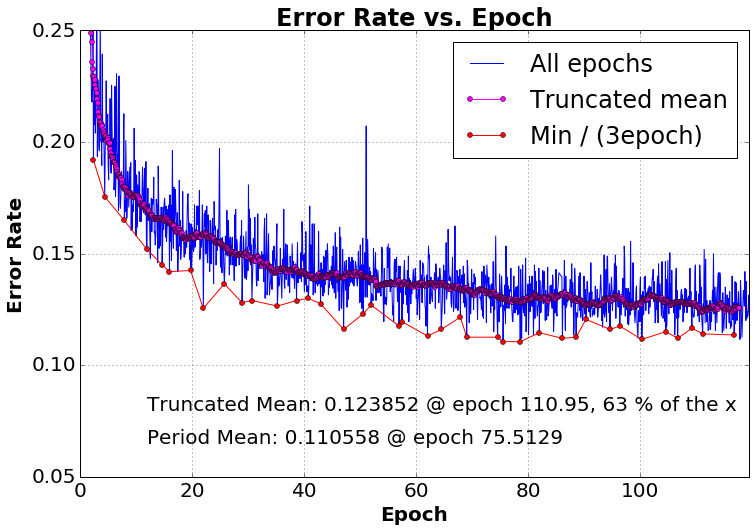

Truncated mean min @ 110.95035 epoch
Printing iteration number within +/- 5 epochs...
Iteration 302750.0 (@ epoch 105.96285 )
Iteration 303000.0 (@ epoch 106.05035 )
Iteration 303250.0 (@ epoch 106.13785 )
Iteration 303500.0 (@ epoch 106.22535 )
Iteration 303750.0 (@ epoch 106.31285 )
Iteration 304000.0 (@ epoch 106.40035 )
Iteration 304250.0 (@ epoch 106.48785 )
Iteration 304500.0 (@ epoch 106.57535 )
Iteration 304750.0 (@ epoch 106.66285 )
Iteration 305000.0 (@ epoch 106.75035 )
Iteration 305250.0 (@ epoch 106.83785 )
Iteration 305500.0 (@ epoch 106.92535 )
Iteration 305750.0 (@ epoch 107.01285 )
Iteration 306000.0 (@ epoch 107.10035 )
Iteration 306250.0 (@ epoch 107.18785 )
Iteration 306500.0 (@ epoch 107.27535 )
Iteration 306750.0 (@ epoch 107.36285 )
Iteration 307000.0 (@ epoch 107.45035 )
Iteration 307250.0 (@ epoch 107.53785 )
Iteration 307500.0 (@ epoch 107.62535 )
Iteration 307750.0 (@ epoch 107.71285 )
Iteration 308000.0 (@ epoch 107.80035 )
Iteration 308250.0 (@ epoch 107.88

In [6]:
#
# plot network accuracy as a function of epoch
#

# network name
netname='resnet50b'
# best-accuracy per "period"
min_period = 3
# truncated mean # data points for rolling window
tmean_npoints = 20
# truncated mean sigma to exclude anomalies 
tmean_sigma = 1.5
# range (+/-) of epoch around truncated mean to print iteration numbers
search_range = 5

#
# Do plot
#

# make canvas
fig, ax = plt.subplots(figsize=(12, 8),facecolor='w')

# Get raw data points (acc vs. epoch)
pts = iter_epoch_map(netname)


# Get xmax
xmax = pts[:,0].max()

#percent = pts[:,0][pts[:,1].argmax()/ xmax * 100# pts[:,0][pts[:,1]]
#print percent
# Plot raw data point
plt.plot(pts[:,0],1.-pts[:,1],markersize=5,marker='',color='blue',label='All epochs')

# Compute truncated mean
xpts = moving_tmean(pts[:,0],20,1.5)
ypts = moving_tmean(pts[:,1],20,1.5)

plt.plot(xpts,1.-ypts,markersize=5,marker='o',color='magenta',label='Truncated mean')
ax.text(xmax/10., 0.08, r'Truncated Mean: %g @ epoch %g, %.2g %% of the x' % (1. - ypts.max(), xpts[ypts.argmax()],pts[:,0][pts[:,1].argmax()]/ xmax * 100), fontsize=20)


# Compute min-per-period
pts = sparse_data(netname,min_period)
#plt.plot(pts[:,0],1.-pts[:,1],markersize=5,marker='o',color='red',label='Min / (%depoch)' % min_period)
plt.plot(pts[:,0][:-1],1.-pts[:,1][:-1],markersize=5,marker='o',color='red',label='Min / (%depoch)' % min_period)
ax.text(xmax/10., 0.065, r'Period Mean: %g @ epoch %g' % (1. - pts[:,1].max(), pts[:,0][pts[:,1].argmax()]), fontsize=20)

# make it prety
plt.ylim(0.05,0.25)
plt.xlim(0,xmax)
plt.tick_params(labelsize=20)
plt.grid()
plt.xlabel('Epoch',fontsize=20,fontweight='bold')
plt.ylabel('Error Rate',fontsize=20,fontweight='bold')
leg=plt.legend(fontsize=24,loc=1,prop={'size':24})
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.title('Error Rate vs. Epoch',fontsize=24,fontweight='bold')

# save figure
plt.savefig('%s.png' % netname)
# plot :)
plt.show()

#
# Now search for relevant iterations to be inspected using min of truncated mean
#

# Min iter should correspond with min_epoch
pts = iter_epoch_map(netname)
tmean_min_epoch = xpts[ypts.argmax()]
print 'Truncated mean min @',tmean_min_epoch,'epoch'
print 'Printing iteration number within +/-',search_range,'epochs...'
for pt in pts :
    if pt[0] < tmean_min_epoch - search_range: continue
    if pt[0] > tmean_min_epoch + search_range: continue
    print 'Iteration',pt[2],'(@ epoch',pt[0],')'

